In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".9"
os.environ["WANDB_NOTEBOOK_NAME"] = "ssilvae_vs_vae.ipynb"

import functools
from pathlib import Path

from ml_collections import config_dict
import jax
import jax.random as random
import jax.numpy as jnp

jnp.log(jnp.exp(1) - 1.0)
# TODO: figure out why we get CUDA failures this ^ isn't here. 

import tensorflow as tf
import flax
# from flax.training import checkpoints
import orbax.checkpoint
from absl import logging

from src.utils.training import setup_model, get_dataset_splits, train_loop
import src.utils.input as input_utils

# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

/homes/jua23/.virtualenvs/vni/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-05 14:06:51.545141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/homes/jua23/.virtualenvs/vni/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
RUN_EXTRA = False
RETRAIN = False

In [3]:
logging.set_verbosity(logging.INFO)

In [4]:
rng = random.PRNGKey(0)
data_rng, model_rng = random.split(rng)

In [5]:
from experiments.configs.ssilvae_mnist import get_config as  get_ssilvae_config
from experiments.configs.vae_mnist import get_config as get_vae_config

ssilvae_config = get_ssilvae_config("45,50000,7501,1")
vae_config = get_vae_config("45,50000")

In [6]:
train_ds, val_ds, _ = get_dataset_splits(vae_config, data_rng, vae_config.batch_size, vae_config.batch_size)

INFO:absl:Initializing train dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-0.7853981633974483, θ_max=0.7853981633974483, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INF

In [7]:
vae_model, vae_state = setup_model(vae_config, model_rng, train_ds);
ssilvae_model, ssilvae_state = setup_model(ssilvae_config, model_rng, train_ds);

INFO:absl:Initializing model...
INFO:absl:config.model_name = VAE
INFO:absl:config.model = X_given_Z:
  conv_dims: !!python/tuple
  - 256
  - 128
  - 64
  dense_dims: &id001 !!python/tuple
  - 256
  max_2strides: 2
Z_given_X:
  conv_dims: !!python/tuple
  - 64
  - 128
  - 256
  dense_dims: *id001
  max_2strides: 2
latent_dim: 16

INFO:absl:input_size = (28, 28, 1)
INFO:absl:Initializing model...
INFO:absl:
+-----------------------------------+------------------+---------+-----------+----------+
| Name                              | Shape            | Size    | Mean      | Std      |
+-----------------------------------+------------------+---------+-----------+----------+
| params/p_X_given_Z/conv_1/bias    | (256,)           | 256     | 0.0       | 0.0      |
| params/p_X_given_Z/conv_1/kernel  | (3, 3, 3, 256)   | 6,912   | 0.000388  | 0.193    |
| params/p_X_given_Z/conv_2/bias    | (128,)           | 128     | 0.0       | 0.0      |
| params/p_X_given_Z/conv_2/kernel  | (3, 3, 256, 

In [8]:
ssilvae_state.params.keys()

frozen_dict_keys(['p_Xhat_given_Z', 'p_Η_given_Xhat', 'prior_μ', 'prior_σ_', 'q_Z_given_Xhat', 'q_Η_given_X', 'σ_'])

In [9]:
vae_state.params.keys()

frozen_dict_keys(['p_X_given_Z', 'prior_μ', 'prior_σ_', 'q_Z_given_X'])

In [10]:
# define a evaluation functions

@functools.partial(jax.vmap, in_axes=(None, 0, None))
@functools.partial(jax.vmap, in_axes=(None, None, 0))
def vae_iwlb(params, x, rng):
    return vae_model.apply(
        dict(params=params),
        x,
        rng,
        num_samples=300,
        method=vae_model.importance_weighted_lower_bound,
    )

@functools.partial(jax.vmap, in_axes=(None, 0, None))
@functools.partial(jax.vmap, in_axes=(None, None, 0))
def ssilvae_iwlb_vae(params, x, rng):
    return ssilvae_model.apply(
        dict(params=params),
        x,
        rng,
        num_samples=300,
        method=ssilvae_model.importance_weighted_lower_bound_vae,
    )

@functools.partial(jax.vmap, in_axes=(None, 0, None))
@functools.partial(jax.vmap, in_axes=(None, None, 0))
def ssilvae_iwlb_mode(params, x, rng):
    return ssilvae_model.apply(
        dict(params=params),
        x,
        rng,
        num_samples=300,
        method=ssilvae_model.importance_weighted_lower_bound_mode,
    )

@functools.partial(jax.vmap, in_axes=(None, 0, None))
@functools.partial(jax.vmap, in_axes=(None, None, 0))
def ssilvae_iwlb_marginalise(params, x, rng):
    return ssilvae_model.apply(
        dict(params=params),
        x,
        rng,
        num_samples=300,
        method=ssilvae_model.importance_weighted_lower_bound_marginalise,
    )

@functools.partial(jax.vmap, in_axes=(None, 0, None))
@functools.partial(jax.vmap, in_axes=(None, None, 0))
def ssilvae_iwlb_full(params, x, rng):
    return ssilvae_model.apply(
        dict(params=params),
        x,
        rng,
        num_samples=300,
        method=ssilvae_model.importance_weighted_lower_bound_full,
    )

In [11]:
rngs = random.split(data_rng, 2)

## Random Img, random params

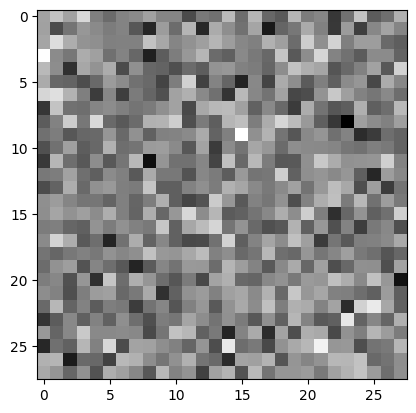

In [12]:
# create a random dummy input to test the models on
x_rng = random.normal(data_rng, (1, 28, 28, 1))

# visualise x using matplotlib.pyplot.imshow
plt.imshow(x_rng[0], cmap="gray")

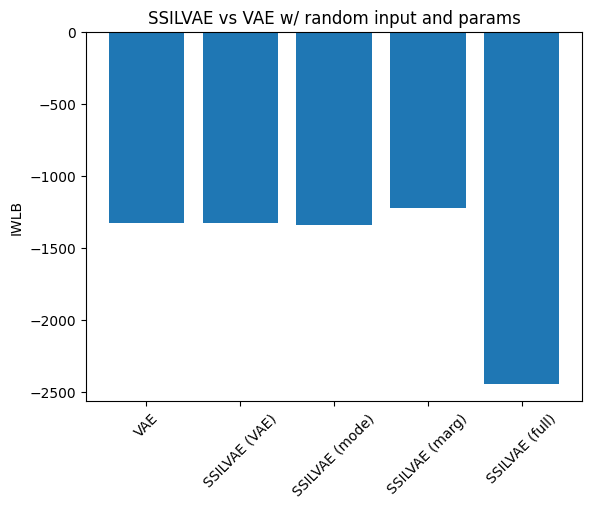

In [13]:
vae_params = vae_state.params
ssilvae_params = ssilvae_state.params

ssilvae_params_dict = dict(ssilvae_params)
ssilvae_params_dict['p_Xhat_given_Z'] = vae_params['p_X_given_Z']
ssilvae_params_dict['q_Z_given_Xhat'] = vae_params['q_Z_given_X']
ssilvae_params_dict['prior_μ'] = vae_params['prior_μ']
ssilvae_params_dict['prior_σ_'] = vae_params['prior_σ_']
ssilvae_params = flax.core.FrozenDict(ssilvae_params_dict)

vae_res = vae_iwlb(vae_params, x_rng, rngs).mean()
ssilvae_res_vae = ssilvae_iwlb_vae(ssilvae_params, x_rng, rngs).mean()
ssilvae_res_mode = ssilvae_iwlb_mode(ssilvae_params, x_rng, rngs).mean()
ssilvae_res_marg = ssilvae_iwlb_marginalise(ssilvae_params, x_rng, rngs).mean()
ssilvae_res_full = ssilvae_iwlb_full(ssilvae_params, x_rng, rngs).mean()

#make a matplotlib bar plot
plt.bar(
    ["VAE", "SSILVAE (VAE)", "SSILVAE (mode)", "SSILVAE (marg)", "SSILVAE (full)"],
    [vae_res, ssilvae_res_vae, ssilvae_res_mode, ssilvae_res_marg, ssilvae_res_full],
)
plt.ylabel("IWLB")
plt.title("SSILVAE vs VAE w/ random input and params")
plt.xticks(rotation=45)
plt.show()

## MNIST Img, random params

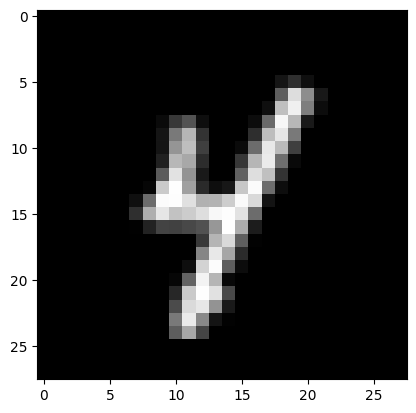

In [14]:
val_iter = input_utils.start_input_pipeline(val_ds, 1)
x_mnist = next(val_iter)['image'][0][:5]

plt.imshow(x_mnist[0], cmap="gray")

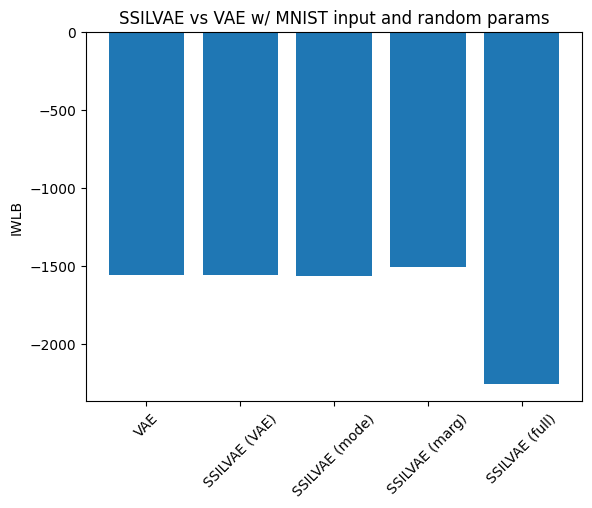

In [15]:
vae_params = vae_state.params
ssilvae_params = ssilvae_state.params

ssilvae_params_dict = dict(ssilvae_params)
ssilvae_params_dict['p_Xhat_given_Z'] = vae_params['p_X_given_Z']
ssilvae_params_dict['q_Z_given_Xhat'] = vae_params['q_Z_given_X']
ssilvae_params_dict['prior_μ'] = vae_params['prior_μ']
ssilvae_params_dict['prior_σ_'] = vae_params['prior_σ_']
ssilvae_params = flax.core.FrozenDict(ssilvae_params_dict)

vae_res = vae_iwlb(vae_params, x_mnist, rngs).mean()
ssilvae_res_vae = ssilvae_iwlb_vae(ssilvae_params, x_mnist, rngs).mean()
ssilvae_res_mode = ssilvae_iwlb_mode(ssilvae_params, x_mnist, rngs).mean()
ssilvae_res_marg = ssilvae_iwlb_marginalise(ssilvae_params, x_mnist, rngs).mean()
ssilvae_res_full = ssilvae_iwlb_full(ssilvae_params, x_mnist, rngs).mean()

#make a matplotlib bar plot
plt.bar(
    ["VAE", "SSILVAE (VAE)", "SSILVAE (mode)", "SSILVAE (marg)", "SSILVAE (full)"],
    [vae_res, ssilvae_res_vae, ssilvae_res_mode, ssilvae_res_marg, ssilvae_res_full],
)
plt.ylabel("IWLB")
plt.title("SSILVAE vs VAE w/ MNIST input and random params")
plt.xticks(rotation=45)
plt.show()

## MNIST Img, vae trained params

### Train the VAE

In [16]:
CKPT_DIR = 'vae_ckpts'
checkpointer = orbax.checkpoint.PyTreeCheckpointer()
vae_ckpt_dir = Path('checkpoints') / 'vae'
vae_ckpt_dir.mkdir(parents=True, exist_ok=True)

if RETRAIN:
    vae_best_state, vae_final_state = train_loop(
        vae_config,
        vae_model,
        vae_state,
        train_ds,
        val_ds,
        wandb_kwargs={
            'mode': 'disabled',
        }
    );

    checkpointer.save(vae_ckpt_dir / 'best', vae_best_state)
    checkpointer.save(vae_ckpt_dir / 'final', vae_final_state) 
    # checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR + '_best', target=vae_best_state, step=0, overwrite=True)
    # checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR + '_final', target=vae_final_state, step=0, overwrite=True)
else:
    # vae_best_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR + '_best', target=vae_state)
    # vae_final_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR + '_final', target=vae_state)
    vae_best_state = checkpointer.restore(vae_ckpt_dir / 'best', item=vae_state)
    vae_final_state = checkpointer.restore(vae_ckpt_dir / 'final', item=vae_state)

INFO:absl:Restoring item from checkpoints/vae/best.


INFO:absl:Finished restoring checkpoint from checkpoints/vae/best.
INFO:absl:Restoring item from checkpoints/vae/final.
INFO:absl:Finished restoring checkpoint from checkpoints/vae/final.


###  Make plots

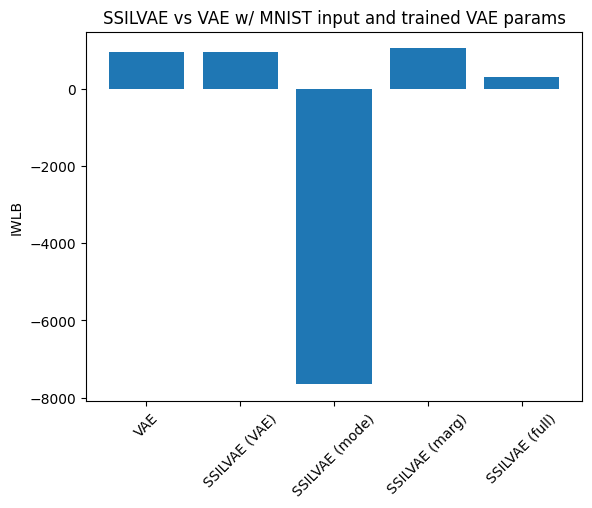

In [17]:
vae_params = vae_best_state.params
ssilvae_params = ssilvae_state.params

ssilvae_params_dict = dict(ssilvae_params)
ssilvae_params_dict['p_Xhat_given_Z'] = vae_params['p_X_given_Z']
ssilvae_params_dict['q_Z_given_Xhat'] = vae_params['q_Z_given_X']
ssilvae_params_dict['prior_μ'] = vae_params['prior_μ']
ssilvae_params_dict['prior_σ_'] = vae_params['prior_σ_']
ssilvae_params = flax.core.FrozenDict(ssilvae_params_dict)

vae_res = vae_iwlb(vae_params, x_mnist, rngs).mean()
ssilvae_res_vae = ssilvae_iwlb_vae(ssilvae_params, x_mnist, rngs).mean()
ssilvae_res_mode = ssilvae_iwlb_mode(ssilvae_params, x_mnist, rngs).mean()
ssilvae_res_marg = ssilvae_iwlb_marginalise(ssilvae_params, x_mnist, rngs).mean()
ssilvae_res_full = ssilvae_iwlb_full(ssilvae_params, x_mnist, rngs).mean()

#make a matplotlib bar plot
plt.bar(
    ["VAE", "SSILVAE (VAE)","SSILVAE (mode)", "SSILVAE (marg)", "SSILVAE (full)"],
    [vae_res, ssilvae_res_vae, ssilvae_res_mode, ssilvae_res_marg, ssilvae_res_full],
)
plt.ylabel("IWLB")
plt.title("SSILVAE vs VAE w/ MNIST input and trained VAE params")
plt.xticks(rotation=45)
plt.show()

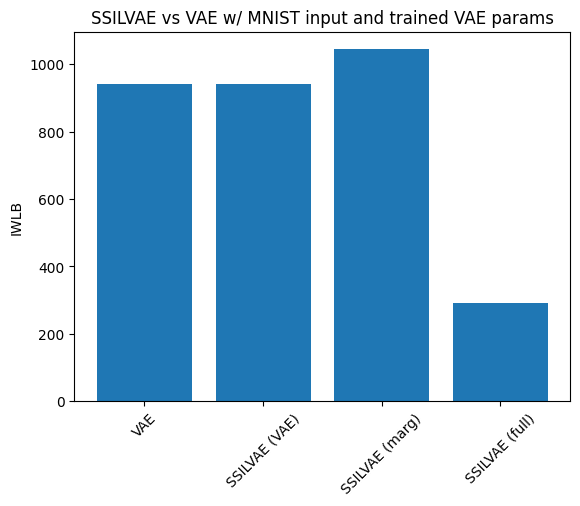

In [18]:
plt.bar(
    ["VAE", "SSILVAE (VAE)", "SSILVAE (marg)", "SSILVAE (full)"],
    [vae_res, ssilvae_res_vae, ssilvae_res_marg, ssilvae_res_full],
)
plt.ylabel("IWLB")
plt.title("SSILVAE vs VAE w/ MNIST input and trained VAE params")
plt.xticks(rotation=45)
plt.show()

## MNIST img, both trained params

### Train the SSIL VAE

In [19]:
ssilvae_state.params.keys()

frozen_dict_keys(['p_Xhat_given_Z', 'p_Η_given_Xhat', 'prior_μ', 'prior_σ_', 'q_Z_given_Xhat', 'q_Η_given_X', 'σ_'])

In [20]:
CKPT_DIR = 'ssilvae_ckpts'
checkpointer = orbax.checkpoint.PyTreeCheckpointer()
ssilvae_ckpt_dir = Path('checkpoints') / 'ssilvae'
ssilvae_ckpt_dir.mkdir(parents=True, exist_ok=True)

if RETRAIN:
    ssilvae_best_state, ssilvae_final_state = train_loop(
        ssilvae_config,
        ssilvae_model,
        ssilvae_state,
        train_ds,
        val_ds,
        wandb_kwargs={
            'mode': 'disabled',
        }
    );

    
    checkpointer.save(ssilvae_ckpt_dir / 'best', ssilvae_best_state)
    checkpointer.save(ssilvae_ckpt_dir / 'final', ssilvae_final_state) 
    # checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR + '_best', target=ssilvae_best_state, step=0, overwrite=True)
    # checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR + '_final', target=ssilvae_final_state, step=0, overwrite=True)
else:
    # ssilvae_best_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR + '_best', target=ssilvae_state)
    # ssilvae_final_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR + '_final', target=ssilvae_state)
    ssilvae_model, ssilvae_state_ = setup_model(ssilvae_config, model_rng, train_ds, half='second')
    ssilvae_best_state = checkpointer.restore(ssilvae_ckpt_dir / 'best', item=ssilvae_state_)
    ssilvae_final_state = checkpointer.restore(ssilvae_ckpt_dir / 'final', item=ssilvae_state_)

INFO:absl:Initializing model...
INFO:absl:config.model_name = SSILVAE
INFO:absl:config.model = Xhat_given_Z:
  conv_dims: !!python/tuple
  - 256
  - 128
  - 64
  dense_dims: &id001 !!python/tuple
  - 256
  max_2strides: 2
Z_given_Xhat:
  conv_dims: !!python/tuple
  - 64
  - 128
  - 256
  dense_dims: *id001
  max_2strides: 2
bounds: !!python/tuple
- 0.25
- 0.25
- 3.141592653589793
- 0.25
- 0.25
latent_dim: 16
offset: !!python/tuple
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
"\u0397_given_X":
  base:
    conv_dims: !!python/tuple []
    dense_dims: &id002 !!python/tuple
    - 64
    - 32
    - 16
    dropout_rate: 0.0
  conditioner:
    dropout_rate: 0.0
    hidden_dims: &id003 !!python/tuple
    - 256
    - 128
  num_bins: 5
  num_layers: 1
  trunk:
    conv_dims: &id004 !!python/tuple
    - 32
    - 64
    - 128
    dense_dims: *id001
    dropout_rate: 0.0
"\u0397_given_Xhat":
  base:
    conv_dims: !!python/tuple []
    dense_dims: *id002
    dropout_rate: 0.0
  conditioner:
    dropout_rate: 0.0


INFO:absl:
+---------------------------------------------------+------------------+---------+-----------+----------+
| Name                                              | Shape            | Size    | Mean      | Std      |
+---------------------------------------------------+------------------+---------+-----------+----------+
| params/p_Xhat_given_Z/conv_1/bias                 | (256,)           | 256     | 0.0       | 0.0      |
| params/p_Xhat_given_Z/conv_1/kernel               | (3, 3, 3, 256)   | 6,912   | 0.000718  | 0.192    |
| params/p_Xhat_given_Z/conv_2/bias                 | (128,)           | 128     | 0.0       | 0.0      |
| params/p_Xhat_given_Z/conv_2/kernel               | (3, 3, 256, 128) | 294,912 | -1.35e-05 | 0.0208   |
| params/p_Xhat_given_Z/conv_3/bias                 | (64,)            | 64      | 0.0       | 0.0      |
| params/p_Xhat_given_Z/conv_3/kernel               | (3, 3, 128, 64)  | 73,728  | -7.74e-05 | 0.0294   |
| params/p_Xhat_given_Z/dense_0/bia

### Make the plot

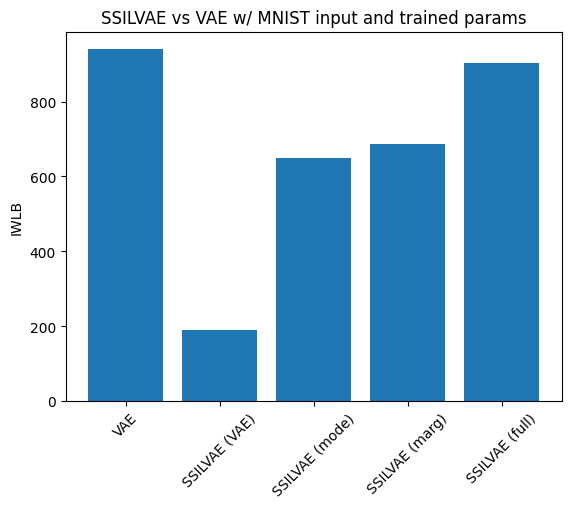

In [21]:
vae_params = vae_best_state.params
ssilvae_params = ssilvae_best_state.params

vae_res = vae_iwlb(vae_params, x_mnist, rngs).mean()
ssilvae_res_vae = ssilvae_iwlb_vae(ssilvae_params, x_mnist, rngs).mean()
ssilvae_res_mode = ssilvae_iwlb_mode(ssilvae_params, x_mnist, rngs).mean()
ssilvae_res_marg = ssilvae_iwlb_marginalise(ssilvae_params, x_mnist, rngs).mean()
ssilvae_res_full = ssilvae_iwlb_full(ssilvae_params, x_mnist, rngs).mean()

#make a matplotlib bar plot
plt.bar(
    ["VAE", "SSILVAE (VAE)", "SSILVAE (mode)", "SSILVAE (marg)", "SSILVAE (full)"],
    [vae_res, ssilvae_res_vae, ssilvae_res_mode, ssilvae_res_marg, ssilvae_res_full],
)
plt.ylabel("IWLB")
plt.title("SSILVAE vs VAE w/ MNIST input and trained params")
plt.xticks(rotation=45)
plt.show()

## MNIST img, both trained params (but copy VAE params)

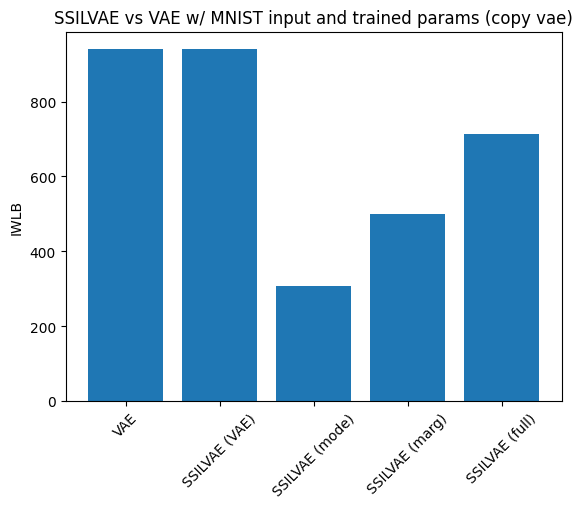

In [22]:
vae_params = vae_best_state.params
ssilvae_params = ssilvae_best_state.params

ssilvae_params_dict = dict(ssilvae_params)
ssilvae_params_dict['p_Xhat_given_Z'] = vae_params['p_X_given_Z']
ssilvae_params_dict['q_Z_given_Xhat'] = vae_params['q_Z_given_X']
ssilvae_params_dict['prior_μ'] = vae_params['prior_μ']
ssilvae_params_dict['prior_σ_'] = vae_params['prior_σ_']
ssilvae_params = flax.core.FrozenDict(ssilvae_params_dict)

vae_res = vae_iwlb(vae_params, x_mnist, rngs).mean()
ssilvae_res_vae = ssilvae_iwlb_vae(ssilvae_params, x_mnist, rngs).mean()
ssilvae_res_mode = ssilvae_iwlb_mode(ssilvae_params, x_mnist, rngs).mean()
ssilvae_res_marg = ssilvae_iwlb_marginalise(ssilvae_params, x_mnist, rngs).mean()
ssilvae_res_full = ssilvae_iwlb_full(ssilvae_params, x_mnist, rngs).mean()

#make a matplotlib bar plot
plt.bar(
    ["VAE", "SSILVAE (VAE)", "SSILVAE (mode)", "SSILVAE (marg)", "SSILVAE (full)"],
    [vae_res, ssilvae_res_vae, ssilvae_res_mode, ssilvae_res_marg, ssilvae_res_full],
)
plt.ylabel("IWLB")
plt.title("SSILVAE vs VAE w/ MNIST input and trained params (copy vae)")
plt.xticks(rotation=45)
plt.show()

## Train a standard VAE on the augmented data

### Create the augmented datasets

In [23]:
train_ds_1_epoch, valid_ds_1_epoch, _ = get_dataset_splits(vae_config, data_rng, 500, 500, 1)

INFO:absl:Initializing train dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}


INFO:absl:Features after op RandomRotate(θ_min=-0.7853981633974483, θ_max=0.7853981633974483, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Initializing val dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Running validation for 20 steps for MNIST, train[:10000]
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(

In [24]:
train_batch = next(input_utils.start_input_pipeline(train_ds_1_epoch, ssilvae_config.get("prefetch_to_device", 1)))

In [25]:
@jax.pmap
@functools.partial(jax.vmap, in_axes=(0,), axis_name="image")
def get_proto(x):
    local_rng = random.fold_in(rng, jax.lax.axis_index("image"))
    return ssilvae_model.apply(
        {"params": ssilvae_best_state.params},
        x,
        local_rng,
        return_xhat=True,
        reconstruct_xhat=False,
        sample_η_proto=False,
        sample_η_recon=False,
        sample_z=False,
        sample_xrecon=False,
        sample_xhat=False,
        α=ssilvae_best_state.α,
        train=False,
        method=ssilvae_model.reconstruct,
    )

In [26]:
new_images = get_proto(train_batch["image"])

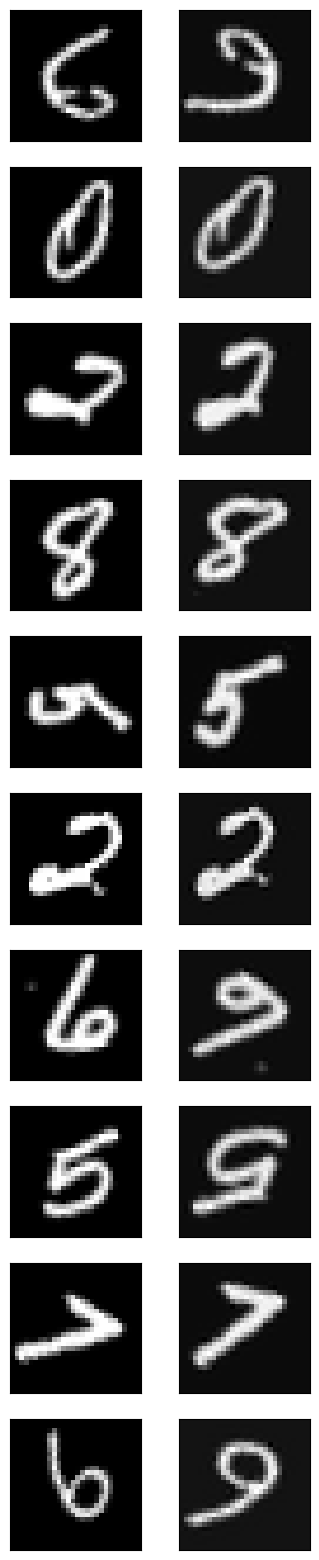

In [27]:
fig, axs = plt.subplots(10, 2, figsize=(4, 20))

for i in range(10):
    axs[i][0].imshow(train_batch["image"][0, i, :, :], cmap="gray")
    axs[i][1].imshow(new_images[0, i, :, :], cmap="gray")
    # remove ticks
    axs[i][0].set_xticks([])
    axs[i][0].set_yticks([])
    axs[i][1].set_xticks([])
    axs[i][1].set_yticks([])

In [28]:
def modify_dataset(dataset_iter):

    modified_dataset = []
    for batch in dataset_iter:
        modified_images = get_proto(batch["image"])
        batch['image'] = modified_images
        modified_dataset.append(batch)

    return modified_dataset


In [29]:
modified_train_data = modify_dataset(
    input_utils.start_input_pipeline(train_ds_1_epoch, ssilvae_config.get("prefetch_to_device", 1))
)
modified_valid_data = modify_dataset(
    input_utils.start_input_pipeline(valid_ds_1_epoch, ssilvae_config.get("prefetch_to_device", 1))
)

In [66]:
def drop_mask(batch):
    batch.pop('mask', None)
    return batch

valid_dataset = tf.data.Dataset.from_generator(
    lambda: (batch for batch in modified_valid_data),
    output_signature={
        'image': tf.TensorSpec(shape=(1, 500, 28, 28, 1), dtype=tf.float32),  # image shape
        'label': tf.TensorSpec(shape=(1, 500), dtype=tf.int32),    # label shape
        'mask': tf.TensorSpec(shape=(1, 500), dtype=tf.float32)    # mask shape
    }
).unbatch().unbatch().filter(lambda x: x['mask'] == 1.).map(drop_mask)

train_dataset = tf.data.Dataset.from_generator(
    lambda: (batch for batch in modified_train_data),
    output_signature={
        'image': tf.TensorSpec(shape=(1, 500, 28, 28, 1), dtype=tf.float32),  # image shape
        'mask': tf.TensorSpec(shape=(1, 500), dtype=tf.float32)    # mask shape
    }
).unbatch().unbatch().filter(lambda x: x['mask'] == 1.).map(drop_mask)

In [67]:
type(next(iter(valid_dataset))['image'])

tensorflow.python.framework.ops.EagerTensor

In [70]:
print(next(train_dataset.as_numpy_iterator())['image'].shape)
print(next(valid_dataset.as_numpy_iterator()).keys())

(28, 28, 1)
dict_keys(['image', 'label'])


### Train the VAE

In [71]:
rng, train_ds_rng = jax.random.split(rng)
train_ds_rng = jax.random.fold_in(train_ds_rng, jax.process_index())

train_ds_aug = input_utils.get_data(
    dataset=train_dataset,
    split='train',
    rng=train_ds_rng,
    process_batch_size=vae_config.batch_size,
    preprocess_fn=None,
    shuffle=vae_config.get("shuffle", "preprocessed"),  # type: ignore
    shuffle_buffer_size=vae_config.shuffle_buffer_size,  # type: ignore
    repeat_after_batching=vae_config.get("repeat_after_batching", True),  # type: ignore
    prefetch_size=vae_config.get("prefetch_to_host", 2),  # type: ignore
    drop_remainder=False,
    num_epochs=None,
)

rng, val_ds_rng = jax.random.split(rng)
val_ds_rng = jax.random.fold_in(val_ds_rng, jax.process_index())

valid_ds_aug = input_utils.get_data(
    dataset=valid_dataset,
    split='valid',  # type: ignore
    rng=val_ds_rng,
    process_batch_size=vae_config.batch_size,
    preprocess_fn=None,
    cache=vae_config.get("val_cache", "batched"),  # type: ignore
    num_epochs=1,
    repeat_after_batching=True,
    shuffle=False,
    prefetch_size=vae_config.get("prefetch_to_host", 2),  # type: ignore
    drop_remainder=False,
)

INFO:absl:Setting up datasets...
INFO:absl:Global batch size 512 on 1 hosts results in 512 local batch size. With 1 devices per host (1 devices total), that's a 512 per-device batch size.
INFO:absl:Initializing train dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-0.785398163397

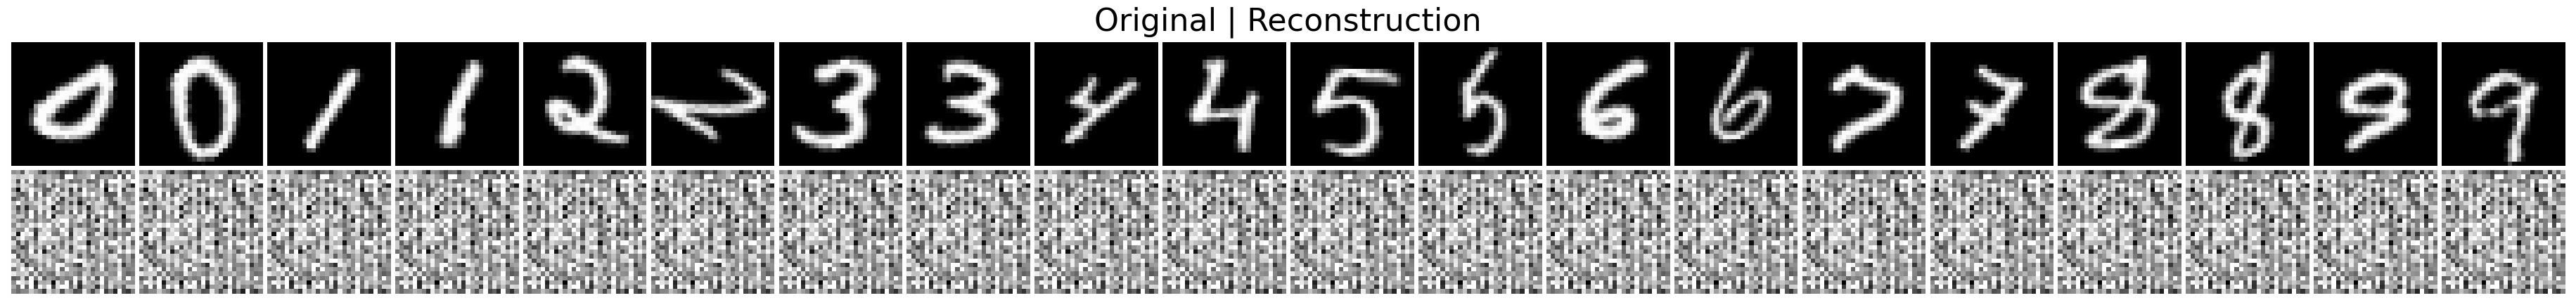

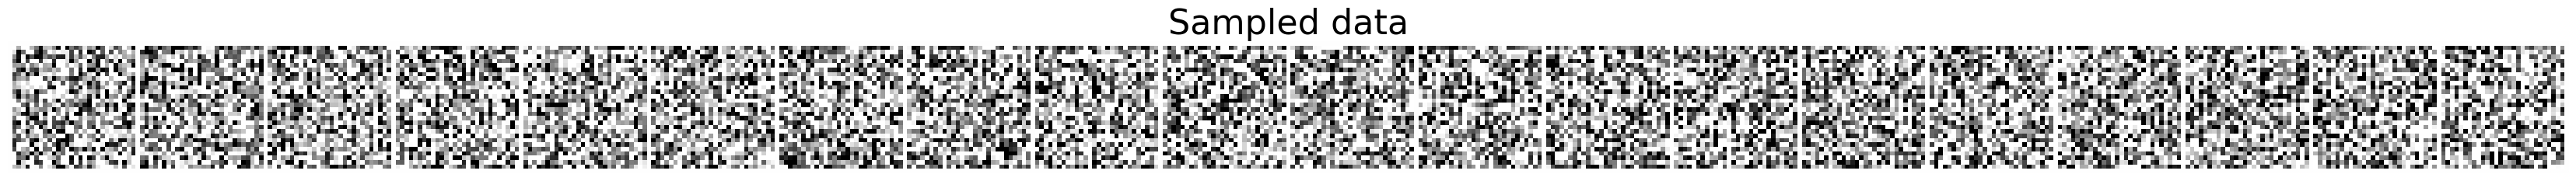

  7%|▋         | 500/7501 [01:40<06:22, 18.31it/s, Trn Loss 743.5,	 Trn LL -743.2,	 Val Loss 1421,	 Val LL -1421] 

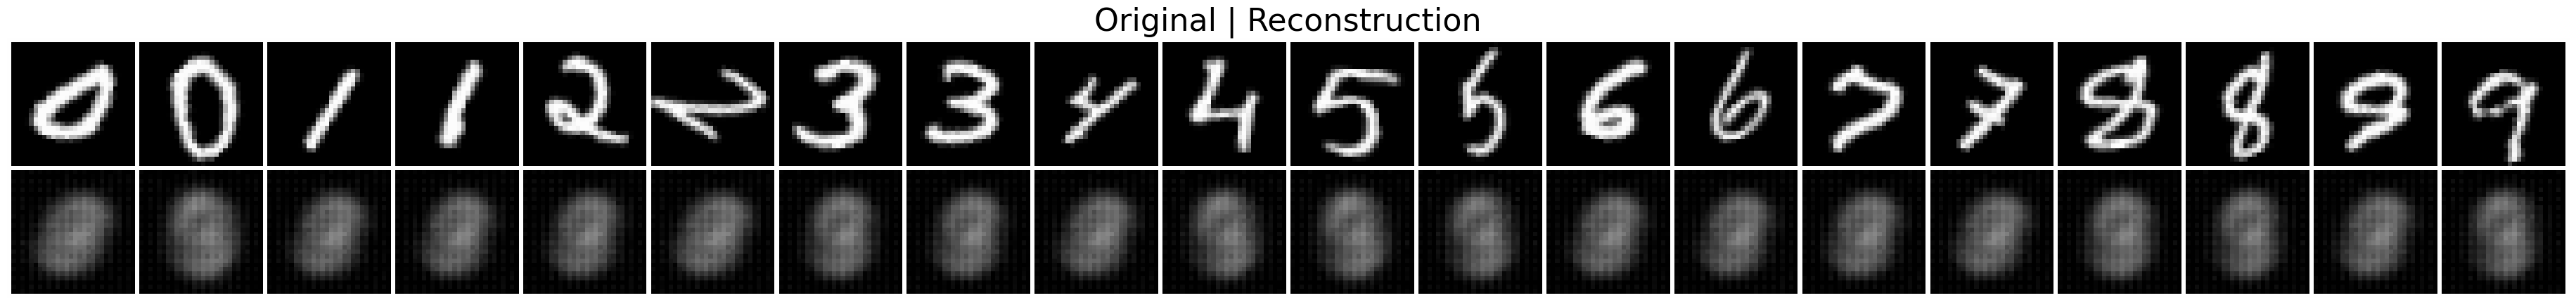

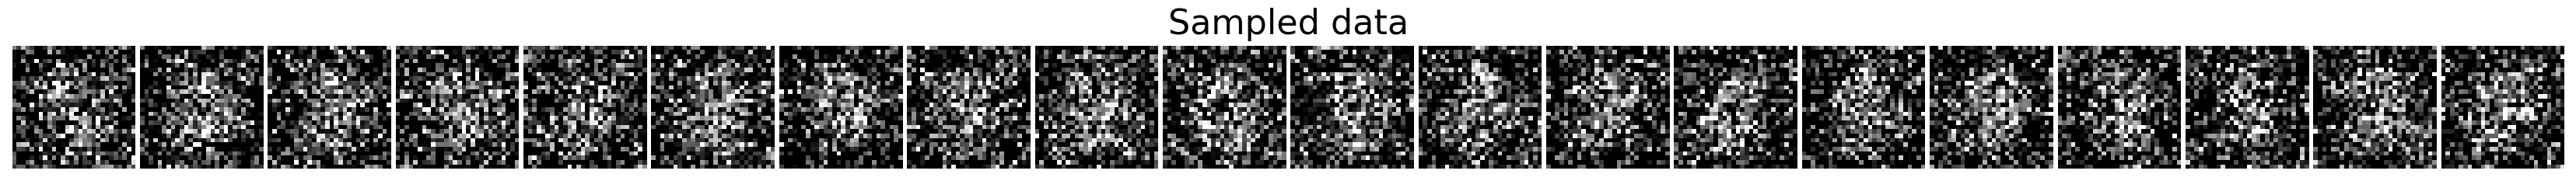

 13%|█▎        | 997/7501 [02:10<04:39, 23.31it/s, Trn Loss 563.5,	 Trn LL -540.6,	 Val Loss 764.9,	 Val LL -764.6]  

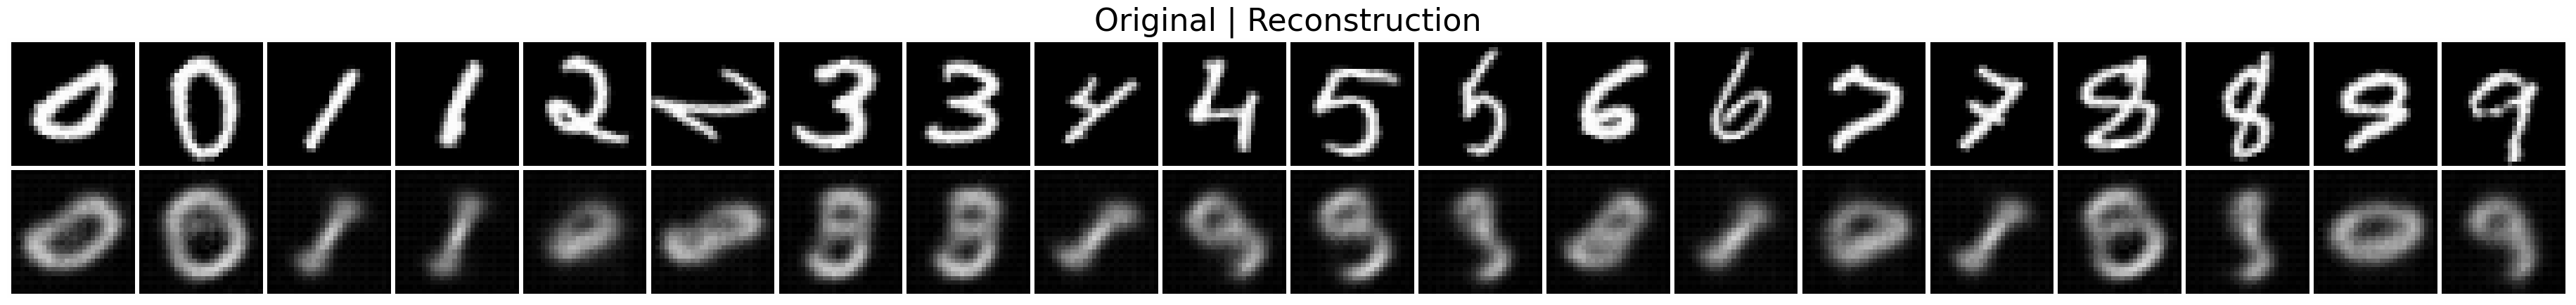

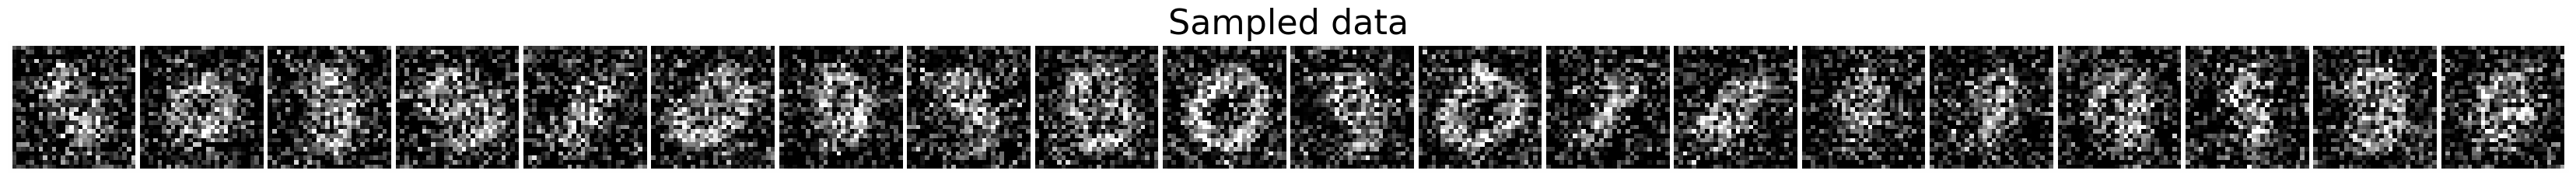

 20%|█▉        | 1497/7501 [02:50<03:18, 30.21it/s, Trn Loss 344.2,	 Trn LL -284.3,	 Val Loss 582.4,	 Val LL -558.7]  

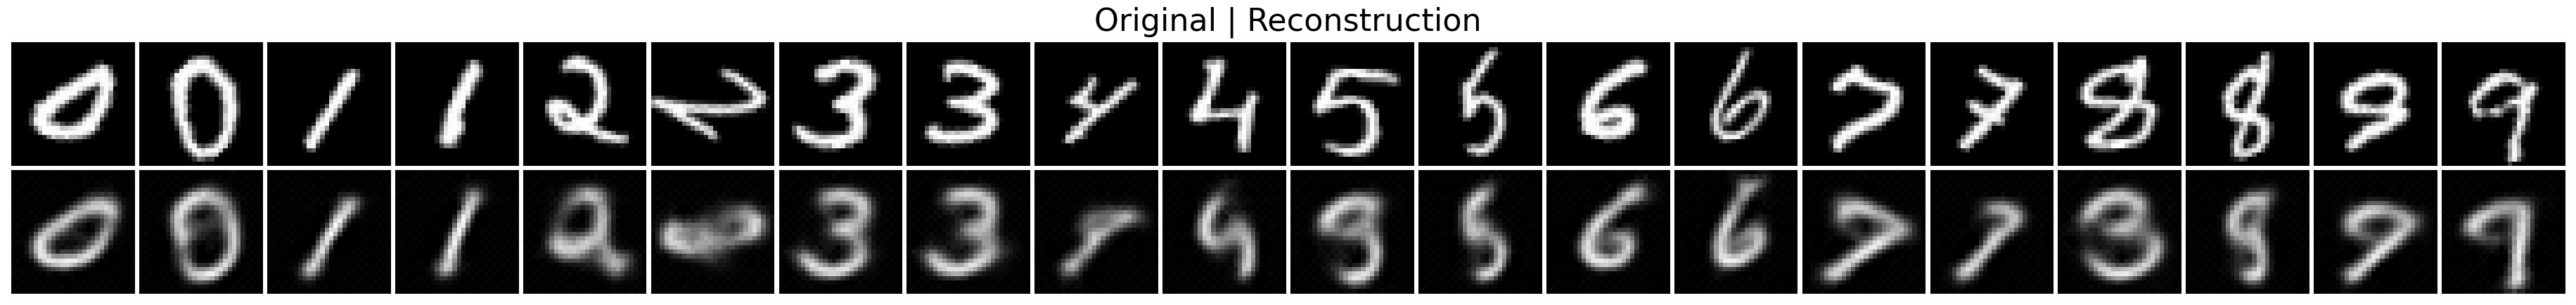

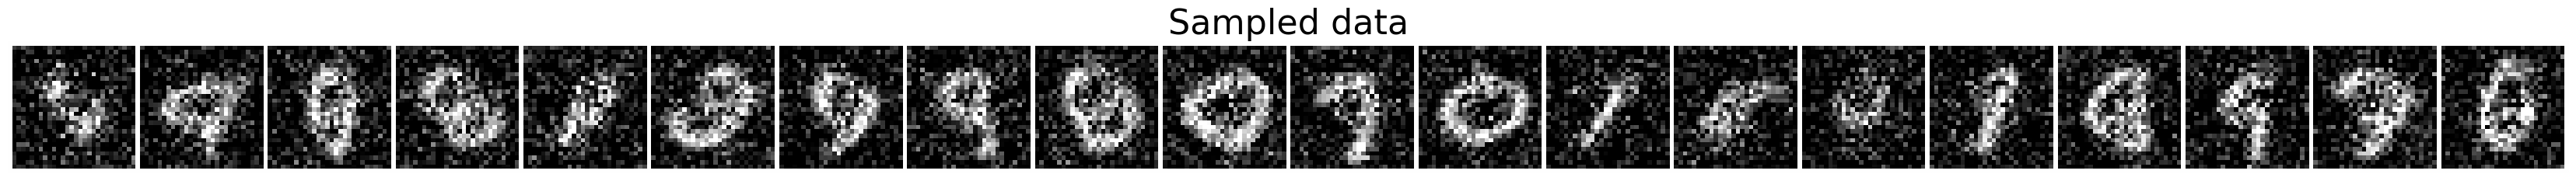

 27%|██▋       | 1998/7501 [03:20<02:35, 35.42it/s, Trn Loss 147.5,	 Trn LL -58.98,	 Val Loss 383,	 Val LL -319.8]    

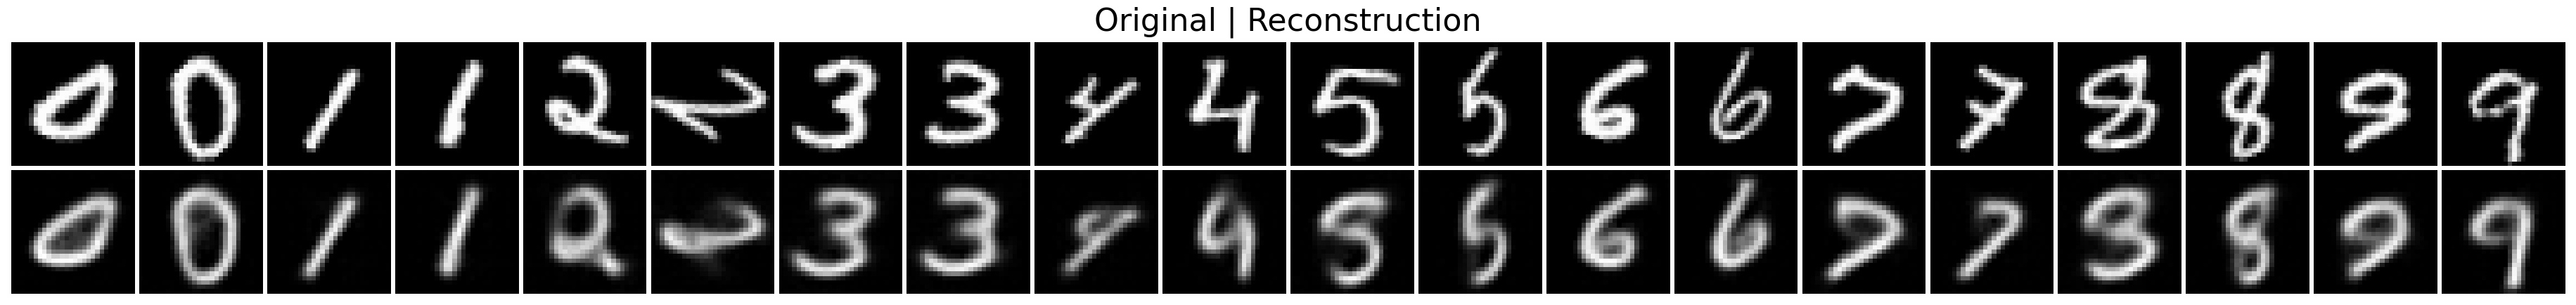

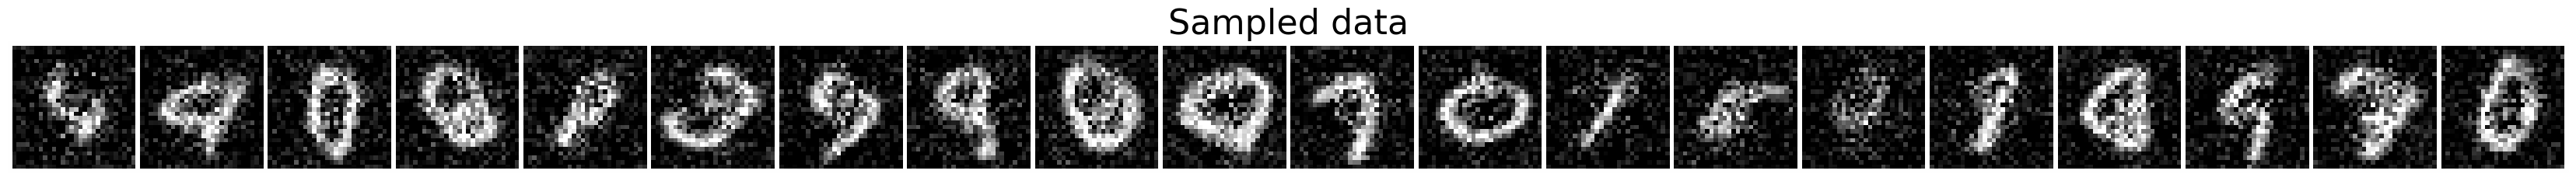

 33%|███▎      | 2498/7501 [04:00<02:17, 36.31it/s, Trn Loss -56.13,	 Trn LL 170.7,	 Val Loss 193.1,	 Val LL -94.89]  

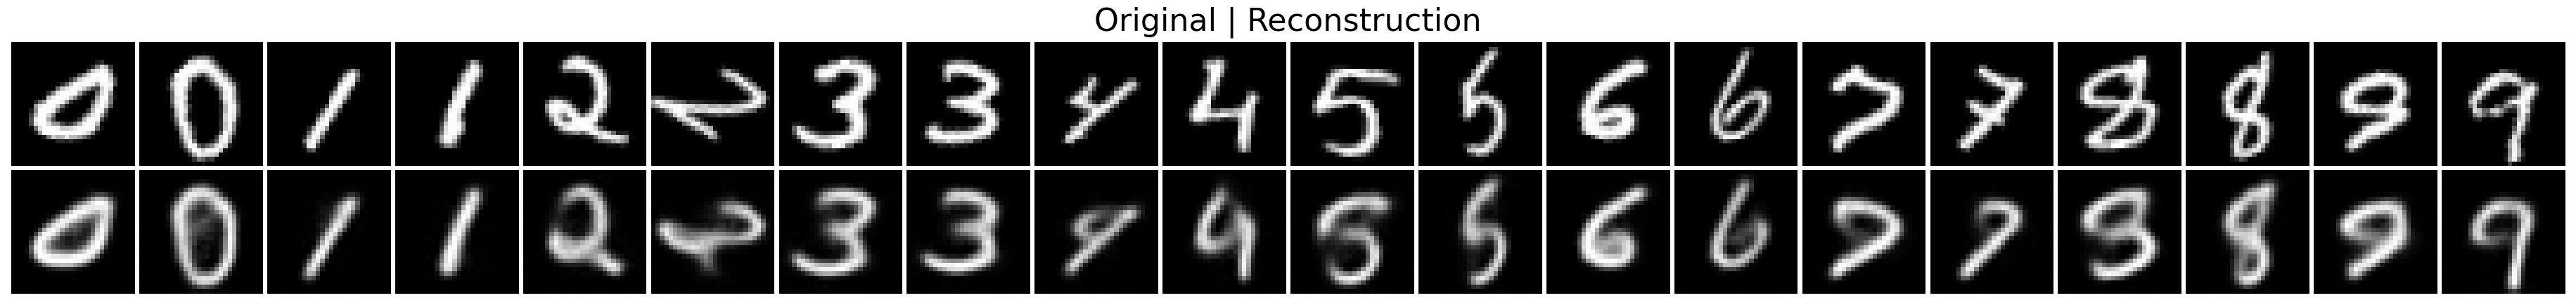

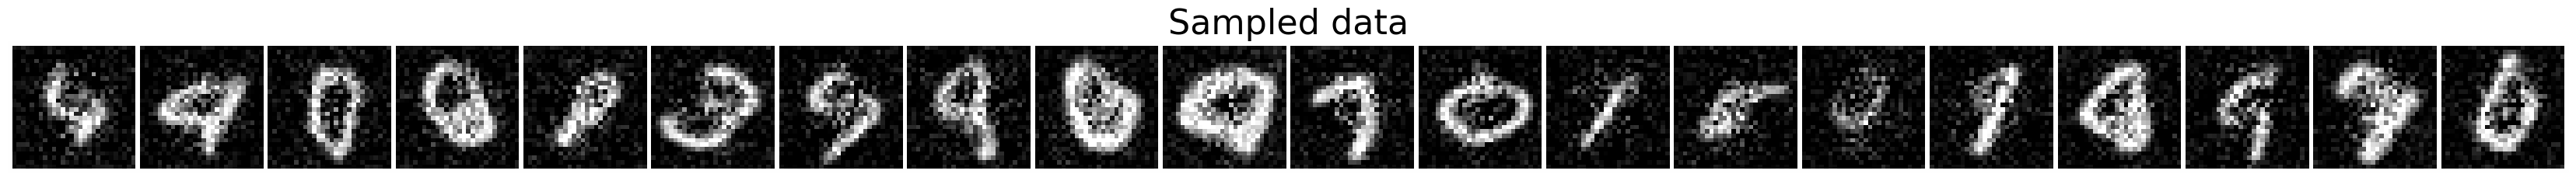

 40%|███▉      | 2997/7501 [04:20<01:55, 39.02it/s, Trn Loss -212.9,	 Trn LL 335.9,	 Val Loss -24.27,	 Val LL 144.7]  

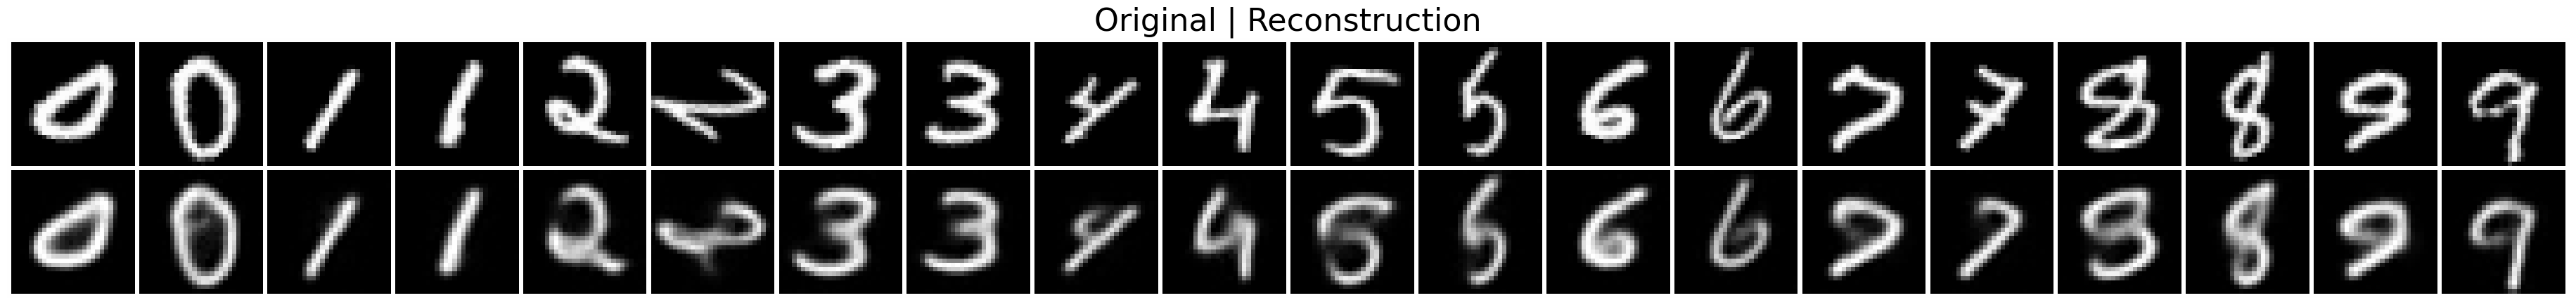

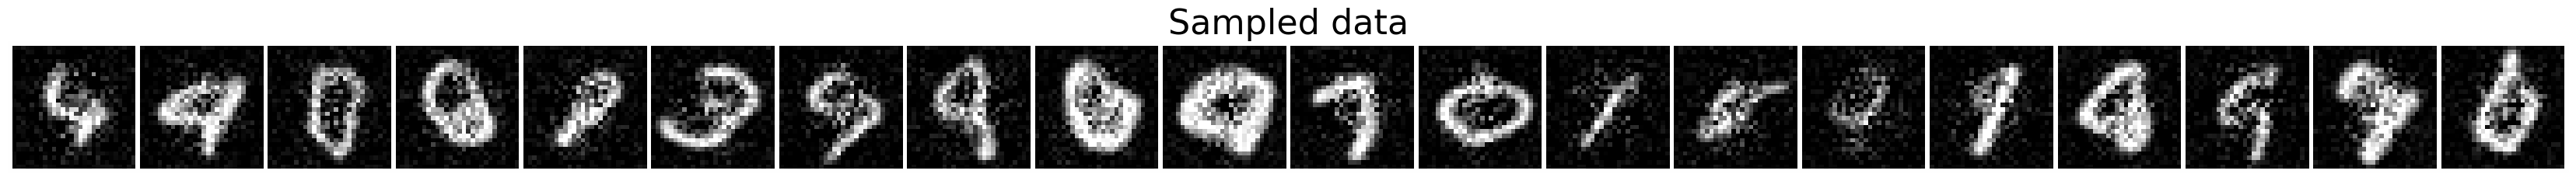

 47%|████▋     | 3500/7501 [05:10<01:43, 38.75it/s, Trn Loss -364.2,	 Trn LL 488.4,	 Val Loss -181.3,	 Val LL 308.7]  

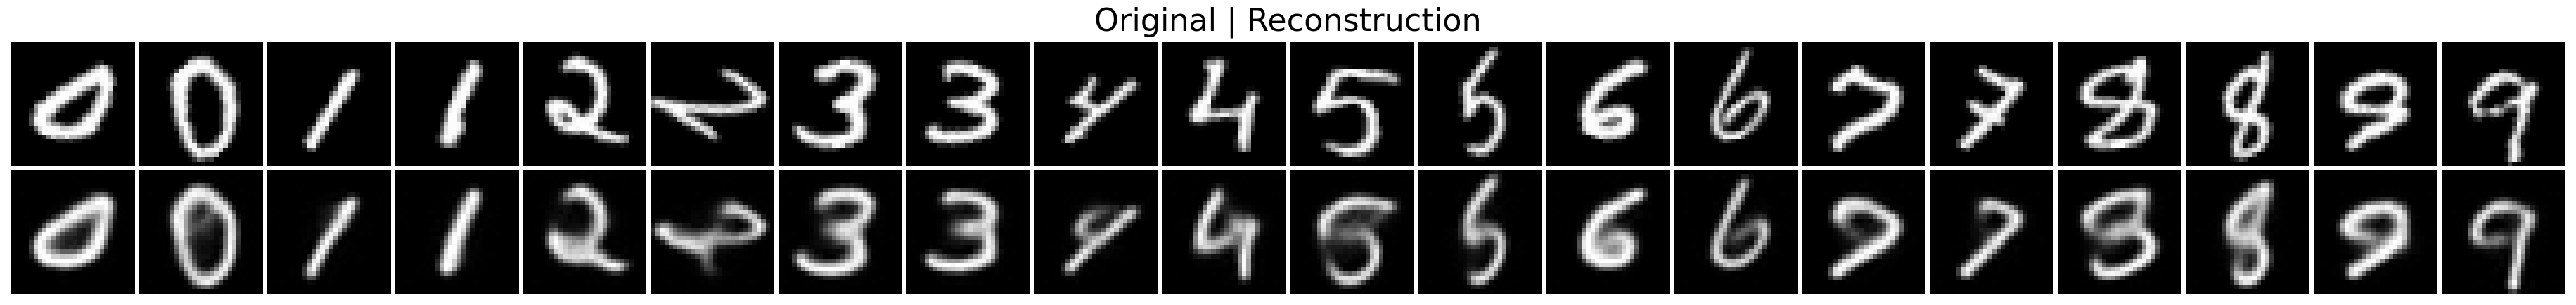

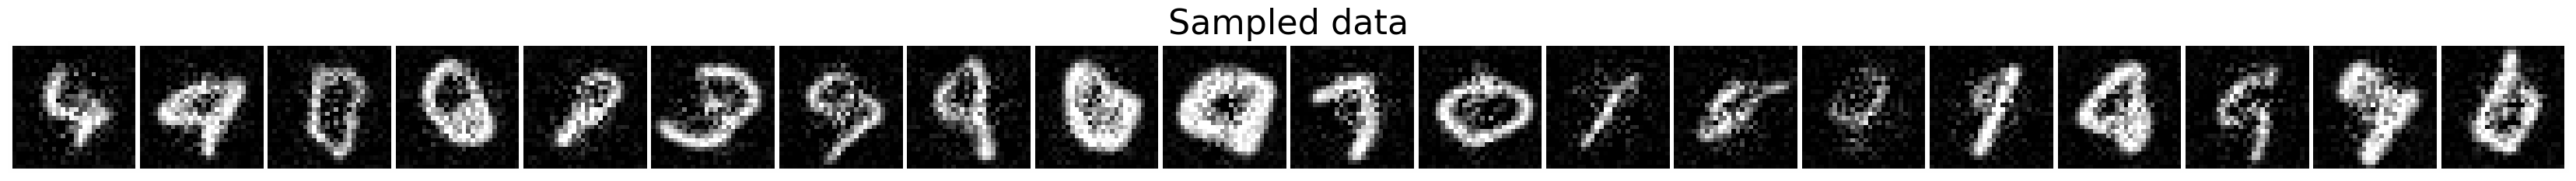

 53%|█████▎    | 3998/7501 [05:40<01:32, 37.73it/s, Trn Loss -485.4,	 Trn LL 606,	 Val Loss -308.7,	 Val LL 437.4]    

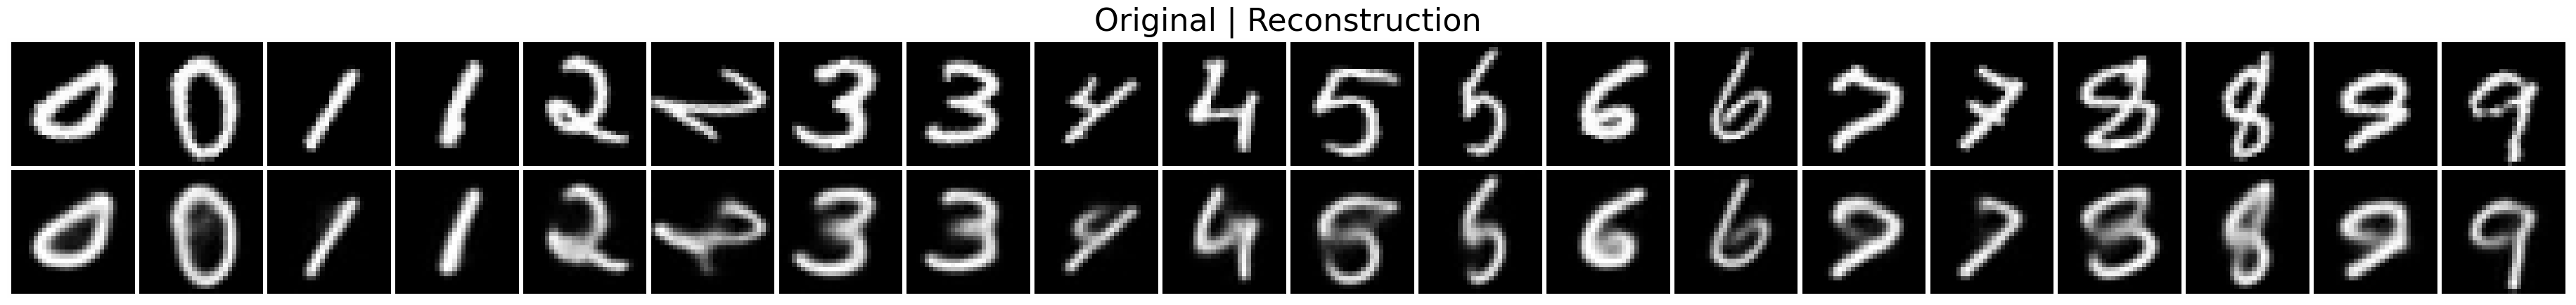

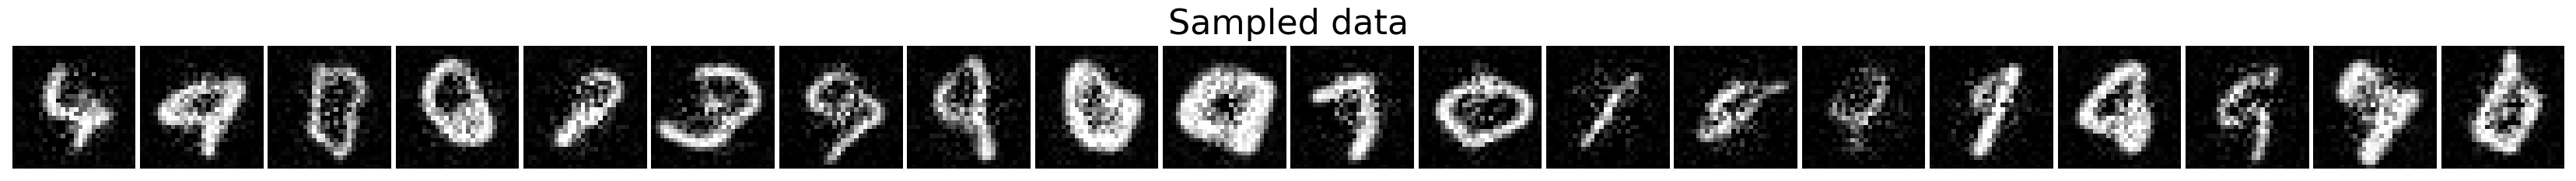

 60%|█████▉    | 4498/7501 [06:20<01:19, 37.94it/s, Trn Loss -570.4,	 Trn LL 682.4,	 Val Loss -468.6,	 Val LL 593.7]  

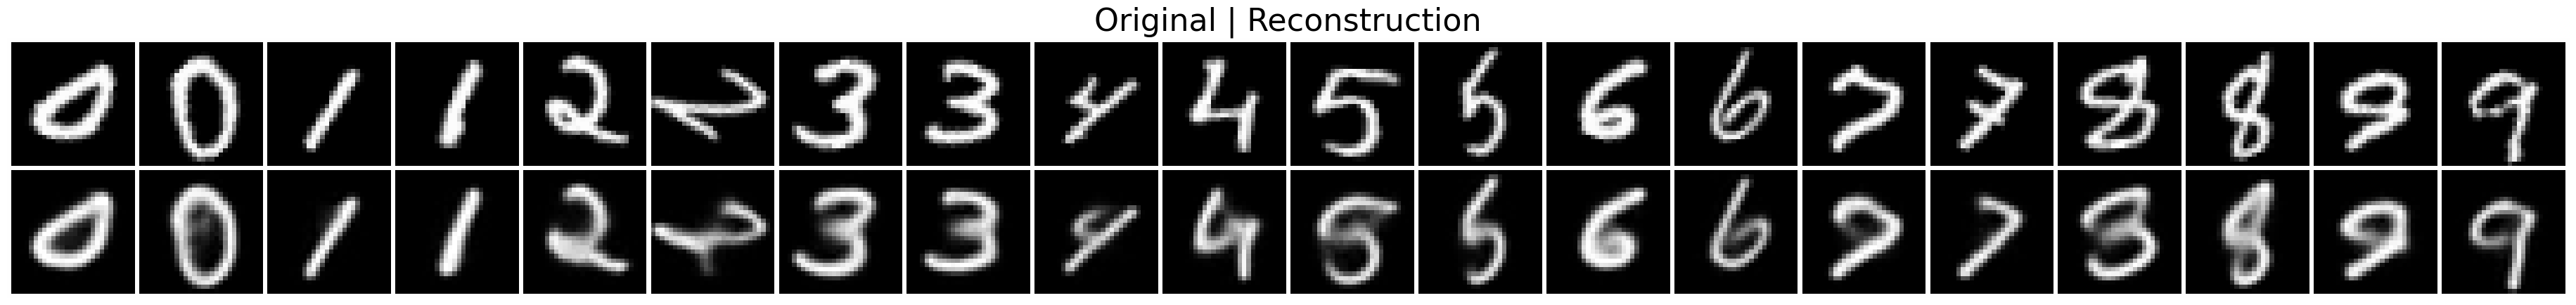

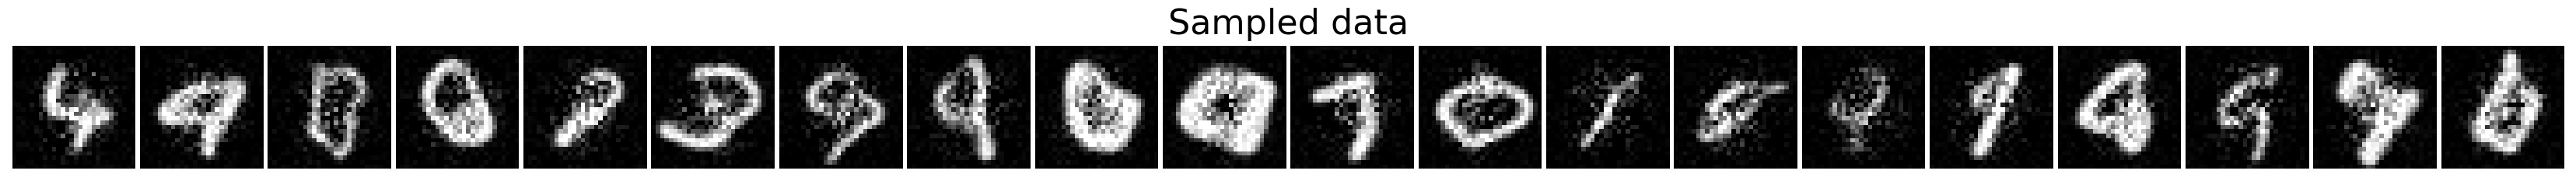

 67%|██████▋   | 5000/7501 [06:41<04:03, 10.27it/s, Trn Loss -661.2,	 Trn LL 755.8,	 Val Loss -557.8,	 Val LL 671.9]  

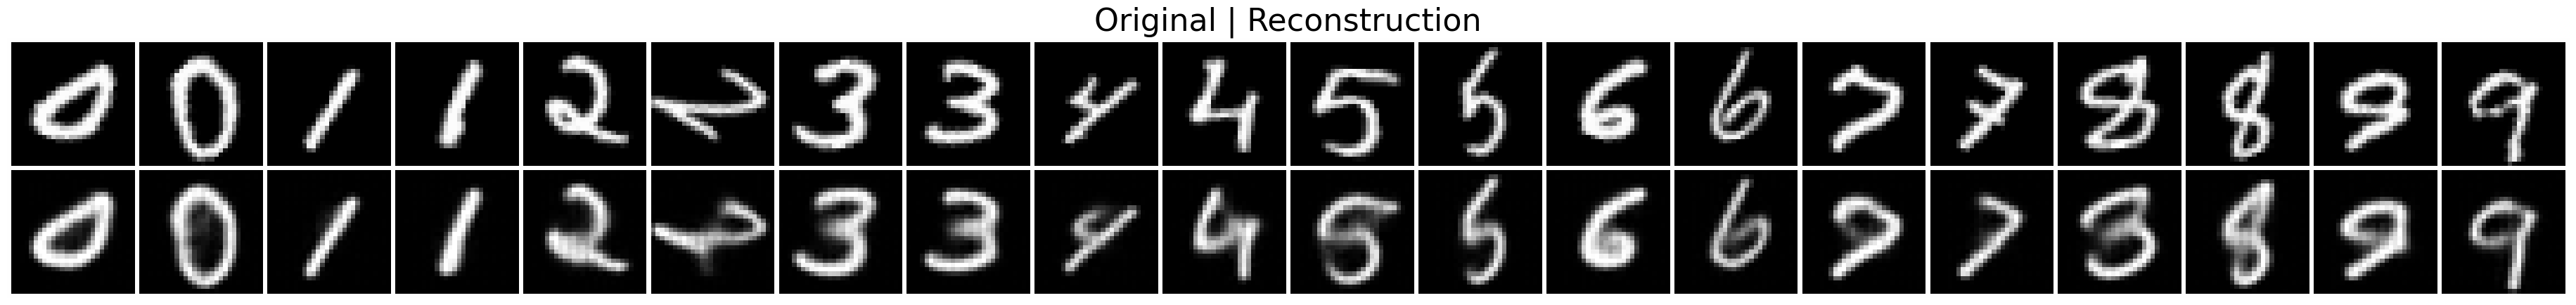

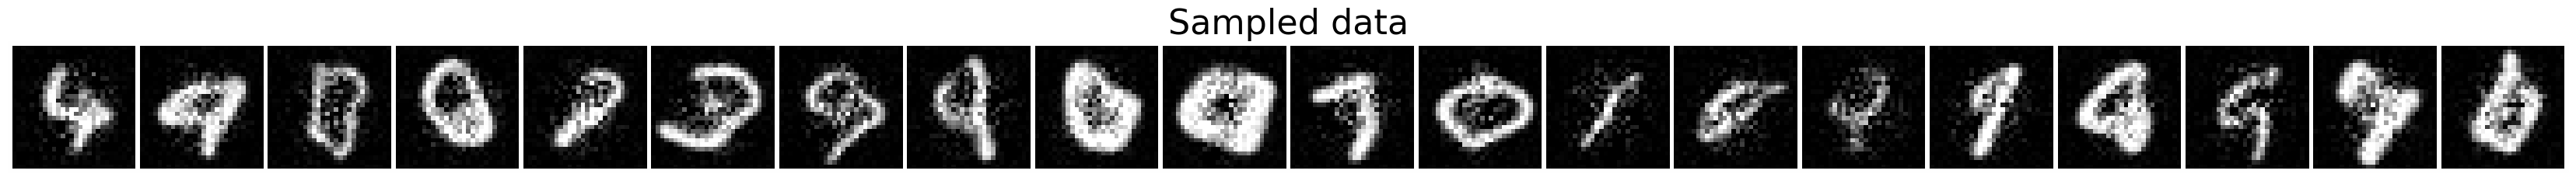

 73%|███████▎  | 5498/7501 [07:30<01:50, 18.09it/s, Trn Loss -733.8,	 Trn LL 815.3,	 Val Loss -665.6,	 Val LL 763.3]  

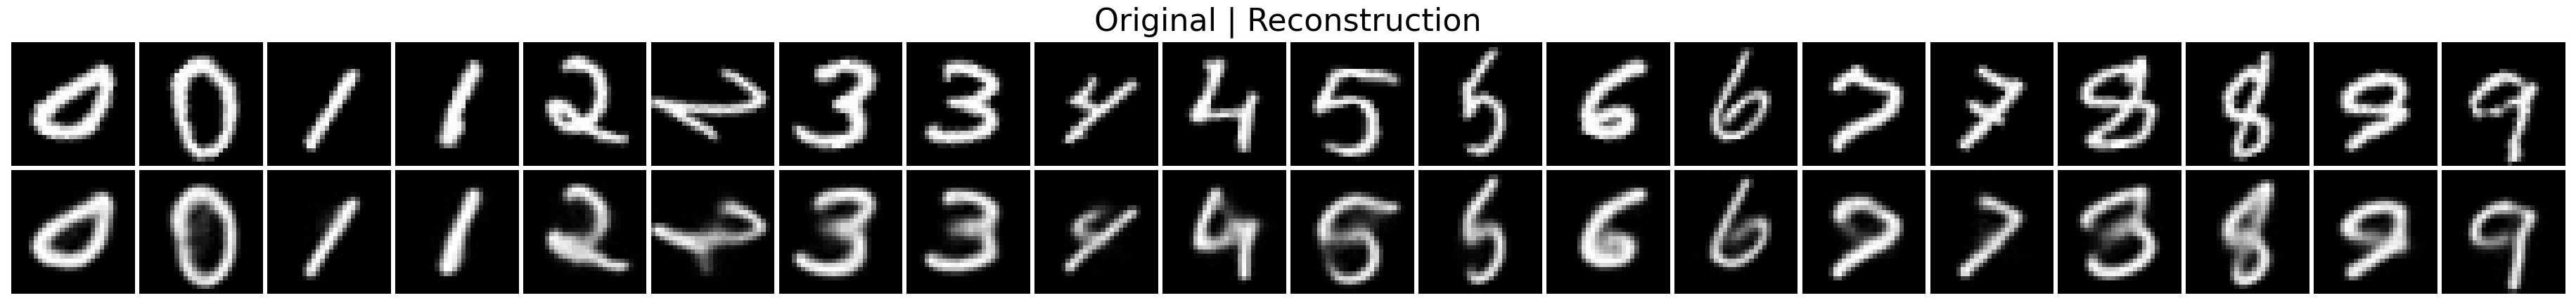

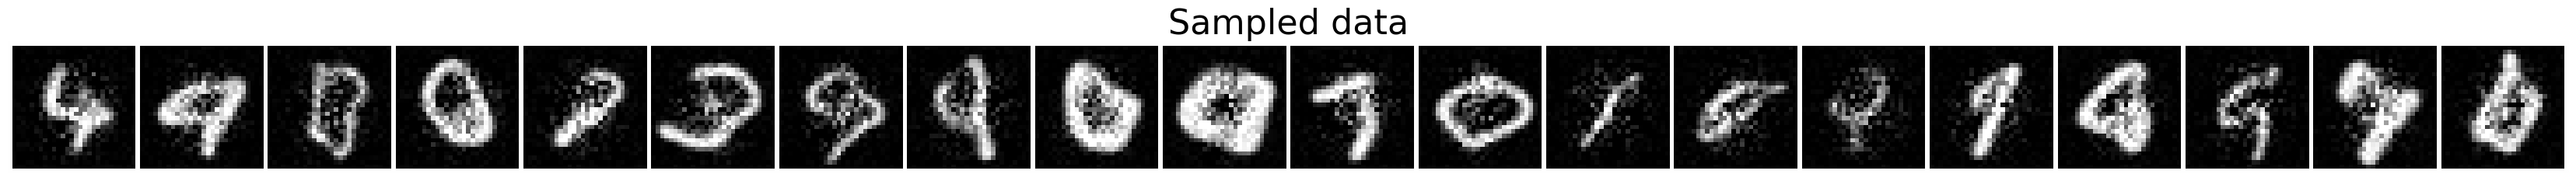

 80%|███████▉  | 6000/7501 [07:52<00:55, 27.19it/s, Trn Loss -810.5,	 Trn LL 876.6,	 Val Loss -737.3,	 Val LL 820.3]

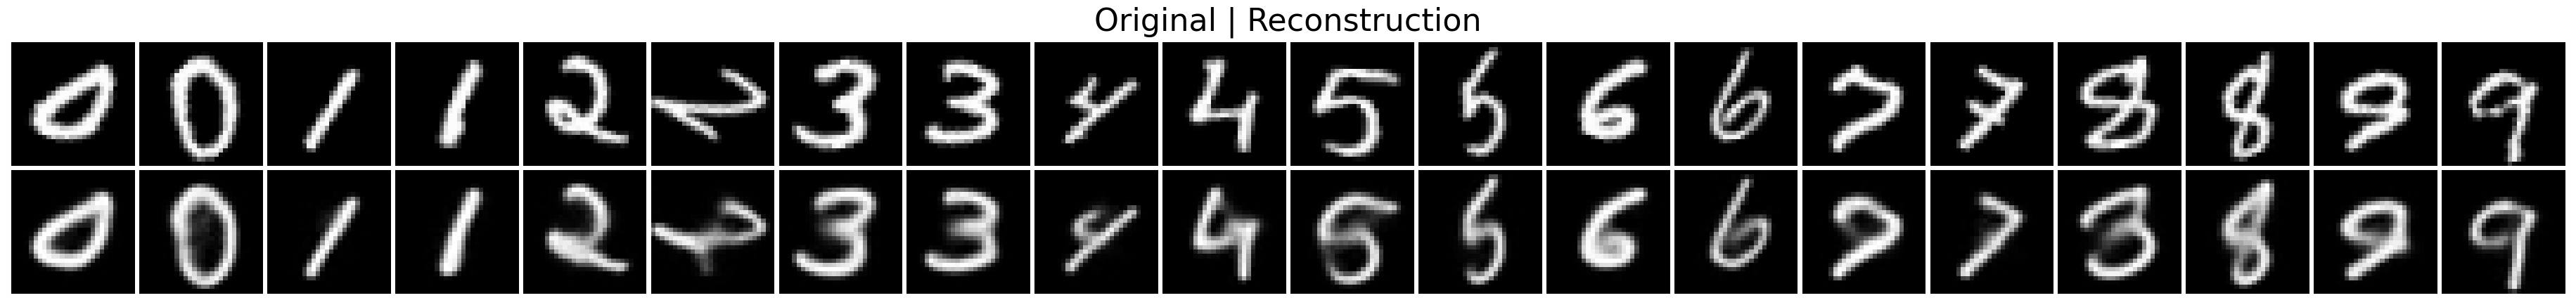

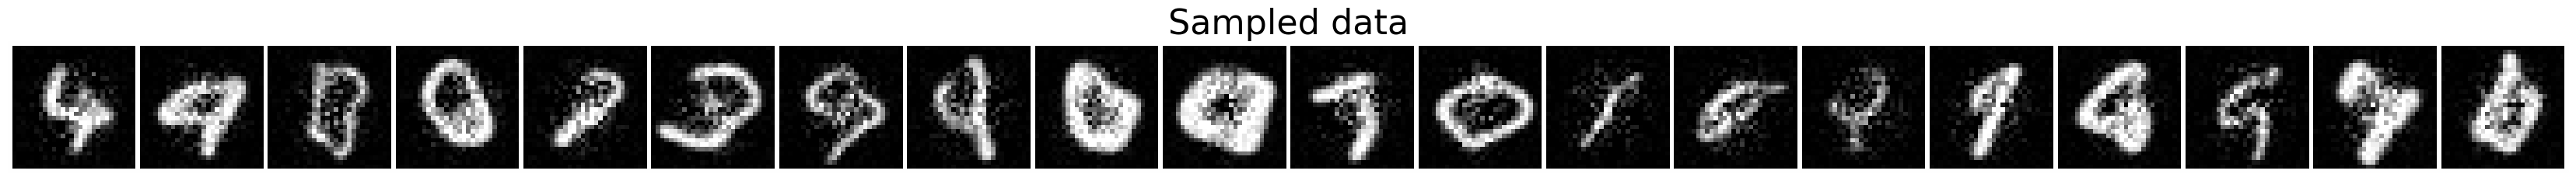

 87%|████████▋ | 6497/7501 [08:40<00:30, 32.97it/s, Trn Loss -866.3,	 Trn LL 918.8,	 Val Loss -797.9,	 Val LL 865.9]

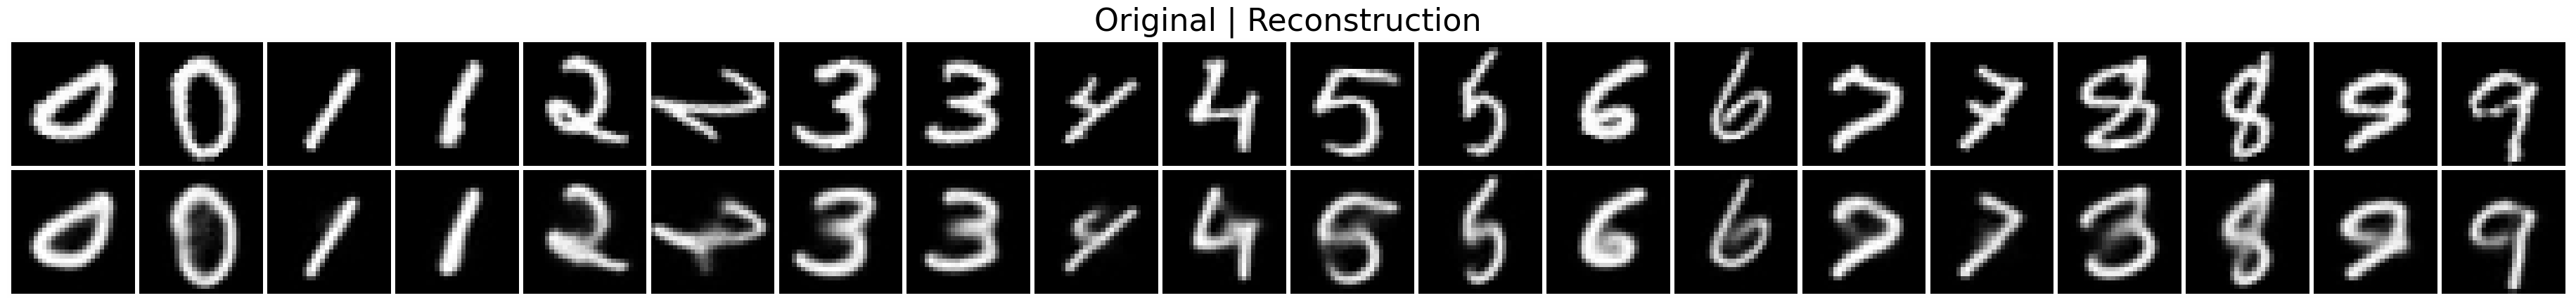

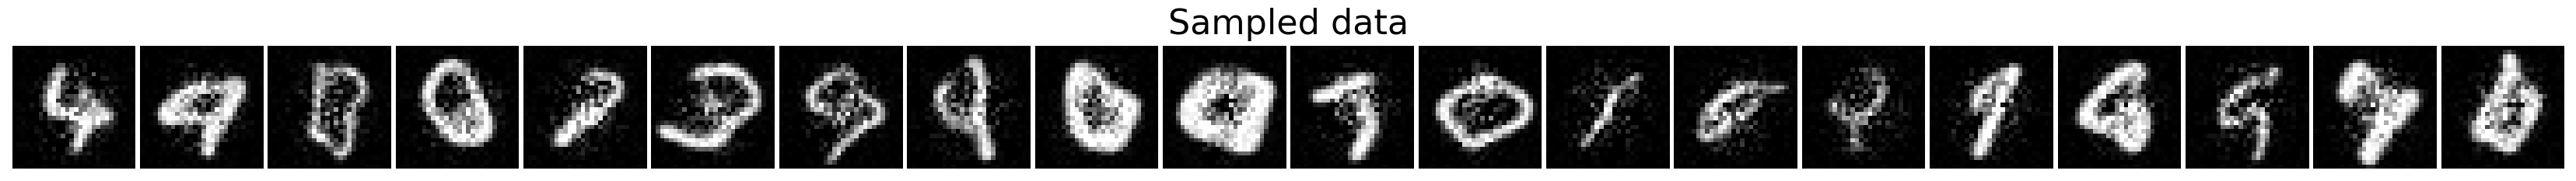

 93%|█████████▎| 6998/7501 [09:03<00:14, 35.22it/s, Trn Loss -884.6,	 Trn LL 929.2,	 Val Loss -836.6,	 Val LL 891.4]

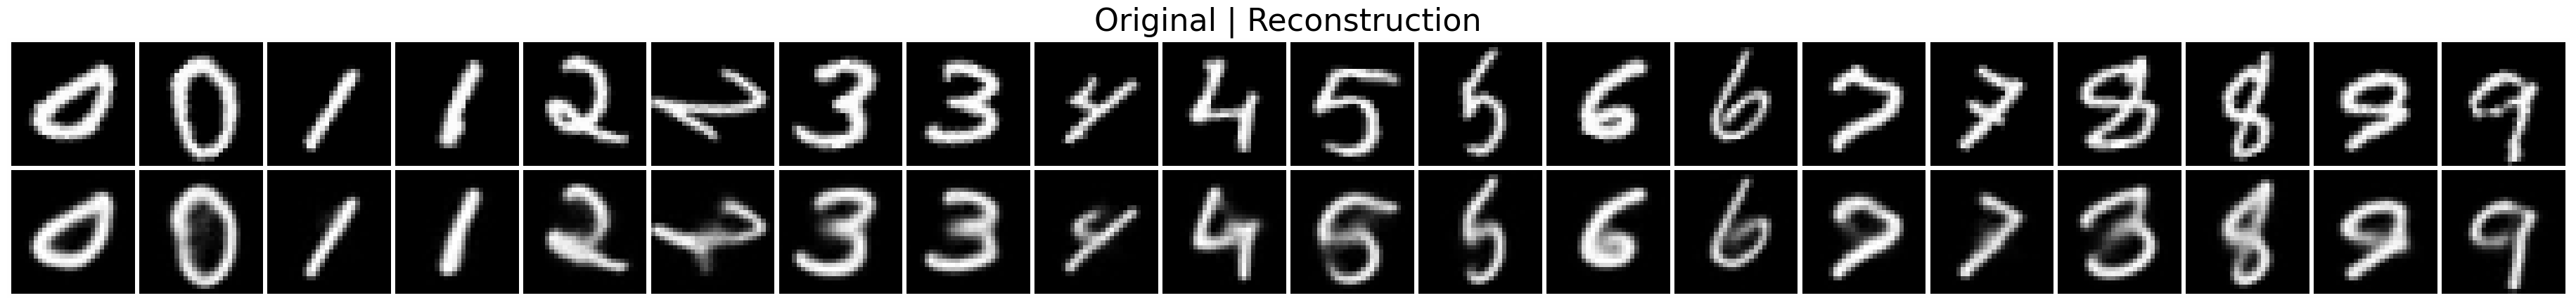

 93%|█████████▎| 6998/7501 [09:20<00:14, 35.22it/s, Trn Loss -884.6,	 Trn LL 929.2,	 Val Loss -836.6,	 Val LL 891.4]

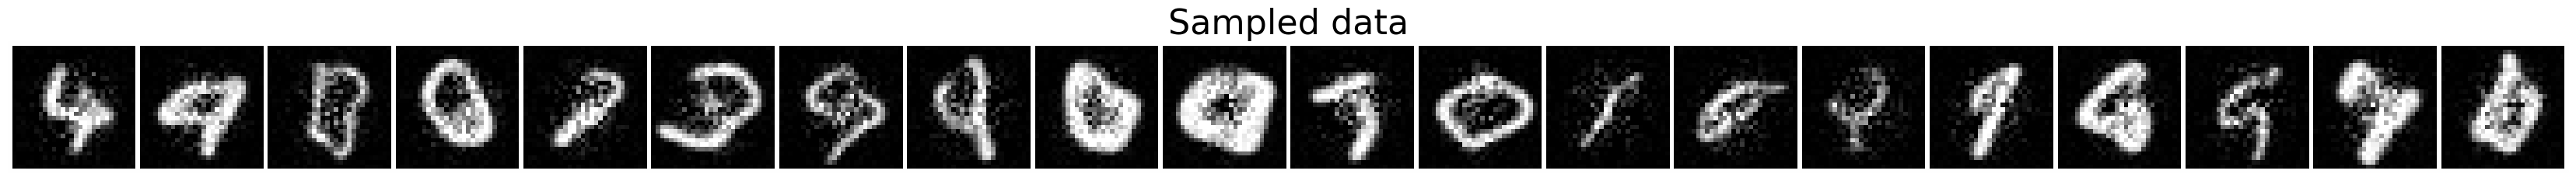

100%|█████████▉| 7499/7501 [09:50<00:00, 35.93it/s, Trn Loss -903.1,	 Trn LL 945.5,	 Val Loss -872.3,	 Val LL 918.5]

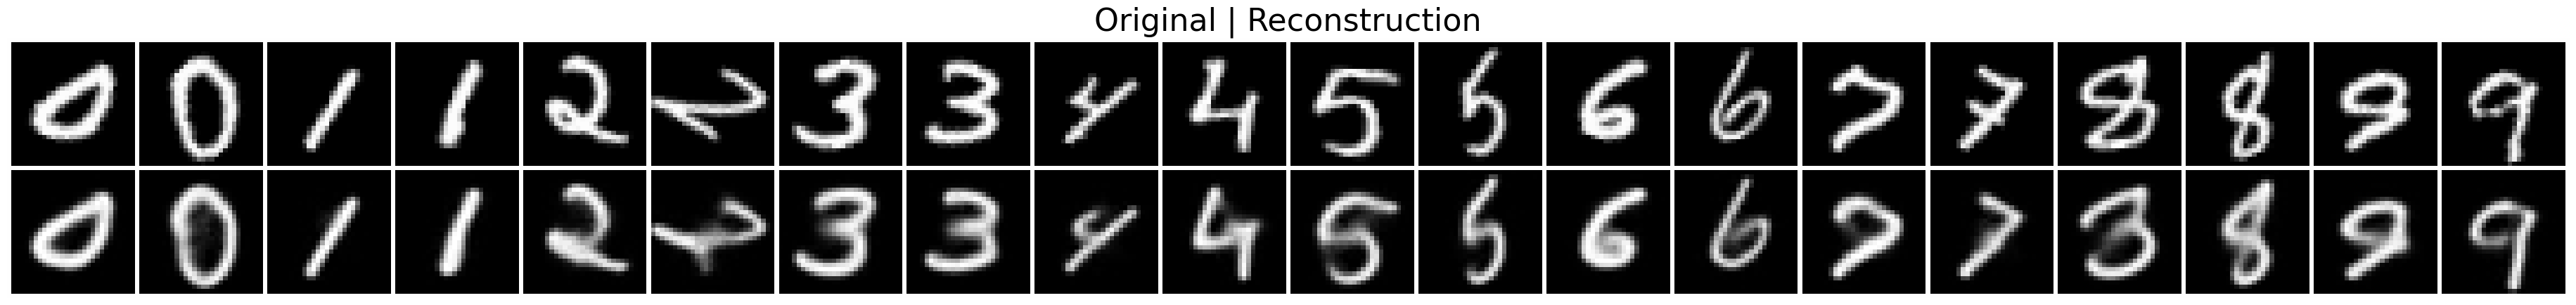

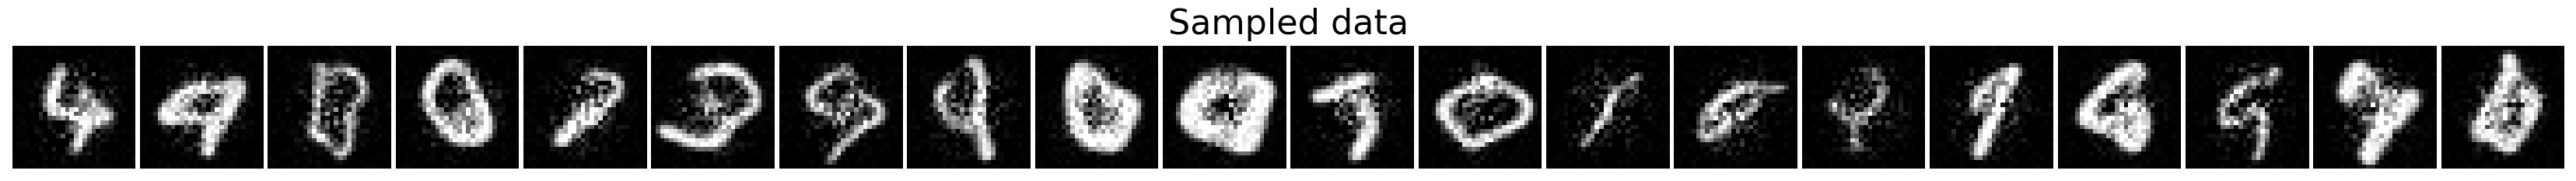

100%|██████████| 7501/7501 [09:56<00:00, 12.58it/s, Trn Loss -903.1,	 Trn LL 945.5,	 Val Loss -872.3,	 Val LL 918.5]
INFO:absl:Training finished.
INFO:absl:Saving item to checkpoints/augvae/best.
INFO:absl:Renaming checkpoints/augvae/best.orbax-checkpoint-tmp-1688566928098178 to checkpoints/augvae/best
INFO:absl:Finished saving checkpoint to `checkpoints/augvae/best`.
INFO:absl:Saving item to checkpoints/augvae/final.
INFO:absl:Renaming checkpoints/augvae/final.orbax-checkpoint-tmp-1688566928518062 to checkpoints/augvae/final
INFO:absl:Finished saving checkpoint to `checkpoints/augvae/final`.


In [73]:
checkpointer = orbax.checkpoint.PyTreeCheckpointer()
augvae_ckpt_dir = Path('checkpoints') / 'augvae'
augvae_ckpt_dir.mkdir(parents=True, exist_ok=True)

if True:
    augvae_best_state, augvae_final_state = train_loop(
        vae_config,
        vae_model,
        vae_state,
        train_ds_aug,
        valid_ds_aug,
        wandb_kwargs={
            'mode': 'disabled',
        }
    );

    checkpointer.save(augvae_ckpt_dir / 'best', augvae_best_state)
    checkpointer.save(augvae_ckpt_dir / 'final', augvae_final_state) 
else:
    augvae_best_state = checkpointer.restore(augvae_ckpt_dir / 'best', item=vae_state)
    augvae_final_state = checkpointer.restore(augvae_ckpt_dir / 'final', item=vae_state)